# 動学BLP（J＝２、R＝１） MPEC

In [1]:
import numpy as np
from scipy.linalg import cholesky
import matplotlib.pyplot as plt
from scipy.interpolate import interpn
from mpl_toolkits.mplot3d import Axes3D
import scipy.special as sp
import pandas as pd
from itertools import product
from scipy.stats import multivariate_normal
import time
import warnings
from scipy.optimize import minimize, BFGS, LinearConstraint, NonlinearConstraint, Bounds

## モデル

In [473]:
class durable_goods_adoption_model():
    
    def __init__(self,
                 ngrid = 20,
                 n_min = 0.1,
                 n_max = 1,
                 nquad = 5,
                 rho = [0.01,0.95,
                        0.09,0.9],
                 cov = [0.005,0.003,
                        0.003,0.005],
                 beta = [5,3],
                 alpha = -4,
                 delta = 0.95):
        
        self.ngrid = ngrid
        self.nquad = nquad
        self.rho = np.array(rho).reshape(2,2)
        self.cov = np.array(cov).reshape(2,2)
        self.delta = delta
        self.alpha = alpha
        self.beta = beta
        self.grid = np.linspace(n_min,n_max,ngrid)
        self.quadrature_setup()

          
    def quadrature_setup(self):     
        self.node, self.weight = np.polynomial.hermite.hermgauss(self.nquad)
        chol_matrix = np.linalg.cholesky(self.cov)
        self.node_psi, self.node_xi = np.sqrt(2)*chol_matrix@np.vstack((self.node,self.node))
        # node_psi , node_xi is array([node_1,...,node_nquad])
        node_psi_xi = np.array(list(product(self.node_psi,self.node_psi,self.node_xi,self.node_xi)))
        # 4 by nquad^4  array. All possible combination of node_psi and node_xi
        weight_psi_xi = np.array(list(product(self.weight/np.sqrt(np.pi),self.weight/np.sqrt(np.pi),self.weight/np.sqrt(np.pi),self.weight/np.sqrt(np.pi))))
        # 4 by nquad^4 array. All possible combination of different weights 
        
        self.node_psi_price1,self.node_psi_price2 = node_psi_xi[:,[0]],node_psi_xi[:,[1]]
        self.node_xi_v1,self.node_xi_v2 = node_psi_xi[:,[2]],node_psi_xi[:,[3]]
        # each node is nquad^4 by 1 array
        self.weight_psi_price1,self.weight_psi_price2 = weight_psi_xi[:,[0]],weight_psi_xi[:,[1]]
        self.weight_xi_v1,self.weight_xi_v2 = weight_psi_xi[:,[2]],weight_psi_xi[:,[3]]
        # each weight is nquad^4 by 1 array
       
    
    def interpolate_V0(self,V0,next_price1,next_price2):
        """
        next_price assume ngrid by nquad^3
        """
        V0 = interpn((self.grid, self.grid),V0,(next_price1,next_price2),
                      method='linear',bounds_error=False,fill_value=None)
        
        return V0 # ngrid*nquad^3 by ngrid*nquad^3 array

        
    def next_period_price(self,current_price1,current_price2):
        """
        current_price is assumed to be scaler(single value)
        """        
        next_period_price1 = self.rho[0,0] + self.rho[0,1]*current_price1 + self.node_psi_price1
        next_period_price2 = self.rho[1,0] + self.rho[1,1]*current_price2 + self.node_psi_price2
        # next_period_price 1 by nquad**3 array
              
        return next_period_price1,next_period_price2
                     
            
    def bellman(self,V0):
        """Bellman operator""" 
        
        current_price1 = np.array(list(product(self.grid, self.grid)))[:,[0]].flatten()
        current_price2 = np.array(list(product(self.grid, self.grid)))[:,[1]].flatten()

        next_price1,next_price2 = self.next_period_price(current_price1,current_price2)
        # next_price is nquad**4 by ngrid**2 array
        v1 =self.beta[0] + self.alpha*next_price1 + self.node_xi_v1# self.delta[0] + self.alpha*next_price1
        v2 =self.beta[1] + self.alpha*next_price2 + self.node_xi_v2 #self.delta[1] + self.alpha*next_price2
        interpolated_V = self.interpolate_V0(V0,next_price1,next_price2)
        # now interpolated_V is nquad**2 by ngrid**2 array
        M = np.maximum(interpolated_V,np.maximum(v1,v2))
        weight = (self.weight_psi_price1*self.weight_psi_price2*self.weight_xi_v1*self.weight_xi_v2).flatten()
        V0 = self.delta*weight@(M + np.log(np.exp(interpolated_V-M) + np.exp(v1-M) + np.exp(v2-M))) 
        V0 = V0.reshape(self.ngrid,self.ngrid)
        
        return V0

        
    def solve_vfi(self,maxiter=10000,tol=1e-8):
        V0 = np.zeros((self.ngrid,self.ngrid))
        for self.iter in range(maxiter):
            V1 = self.bellman(V0)
            err = np.max(np.abs(V1-V0))
            if err < tol:
                break
            V0 = V1
        else:
            raise RuntimeError('No convergence: maximum number of iterations achieved!')
        return V0
    
    
    
    def solve_plot(self):
        
        V0 = self.solve_vfi()
        
        price1 = np.arange(0, V0.shape[0])
        price2 = np.arange(0, V0.shape[1])
        price1, price2 = np.meshgrid(price1, price2)
        
        fig_V0 = plt.figure(figsize=(8, 8))
        ax_V0 = fig_V0.add_subplot(111, projection='3d')
        z = V0.flatten()
        surf = ax_V0.plot_surface(price1, price2, z.reshape(V0.shape), cmap='viridis')
        ax_V0.set_xlabel('price 1')
        ax_V0.set_ylabel('price 2')
        ax_V0.set_zlabel('Value')
        fig_V0.colorbar(surf, ax=ax_V0, shrink=0.5, aspect=10)
        ax_V0.view_init(elev=20, azim=30)
        
        
        plt.show()
        return V0

## 買い控え価値

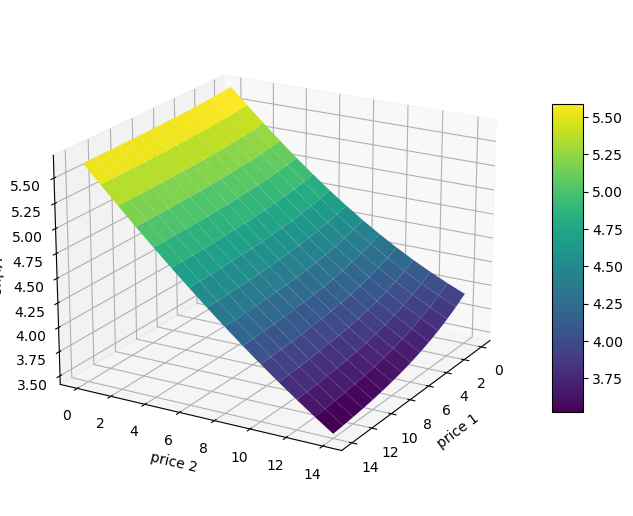

CPU times: total: 812 ms
Wall time: 2.16 s


In [474]:
model = durable_goods_adoption_model(ngrid = 15,nquad = 5)
%time V0 = model.solve_plot()

## データシミュレーション

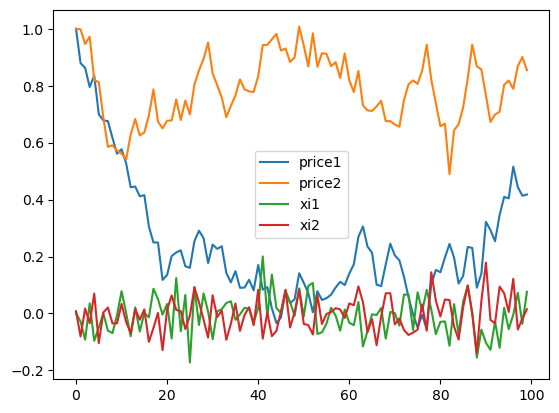

In [475]:
def simulate_price_process(T = 100,
                           price_0 = [1,1],
                           model = model,
                           seed= 1234):
    """
    Return price process
    First column is price process for product 1 and second for product 2.
    Number of row corresponds to time period
    """
    np.random.seed(seed)
    mean = np.array([0, 0])
    
    shocks1 = np.random.multivariate_normal(mean,model.cov,size=T)
    psi1,xi1  = shocks1[:,0],shocks1[:,1]

    shocks2 = np.random.multivariate_normal(mean,model.cov,size=T)
    psi2,xi2 = shocks2[:,0],shocks2[:,1]
    
    price = np.zeros((2,T))
    price[0,0] = np.array(price_0[0])
    price[1,0] = np.array(price_0[1])
    for t in range(1,T):
        price[0,t] = model.rho[0,0] + model.rho[0,1]*price[0,t-1] + psi1[t]
        price[1,t] = model.rho[1,0] + model.rho[1,1]*price[1,t-1] + psi2[t]
    
    return price,xi1,xi2,psi1,psi2

plt.plot(simulate_price_process()[0][0],label = "price1")
plt.plot(simulate_price_process()[0][1],label = "price2")
plt.plot(simulate_price_process()[2],label = "xi1")
plt.plot(simulate_price_process()[3],label = "xi2")
plt.legend()
plt.show()

In [482]:
def simulate_share(T=30,
                   M=500,
                   model=model,
                   price_choice1 = simulate_price_process(seed=1234)[0][0], 
                   price_choice2 = simulate_price_process(seed=1234)[0][1], 
                   xi_choice1 = simulate_price_process(seed=1234)[2],
                   xi_choice2 = simulate_price_process(seed=1234)[3]
                   ):
    init_M = M
    beta_choice1, beta_choice2 = model.beta[0], model.beta[1]
    alpha = model.alpha

    V0 = model.solve_vfi()
    V0 = model.interpolate_V0(V0,price_choice1,price_choice2)
    
    share_choice1, share_choice2 = np.empty(T), np.empty(T)
    share, outside_share = np.empty(T), np.empty(T)
 
    sales_choice1,sales_choice2 = np.empty(T), np.empty(T)
    sales, outside_sales = np.empty(T), np.empty(T)
    
    M = np.empty(T)
    M[0] = init_M


    for t in range(T):
        share_choice1[t] = np.exp(beta_choice1 + alpha * price_choice1[t] + xi_choice1[t] - V0[t]) / (
             np.exp(V0[t]-V0[t]) + 
             np.exp(beta_choice1 + alpha * price_choice1[t] + xi_choice1[t] - V0[t]) +
             np.exp(beta_choice2 + alpha * price_choice2[t] + xi_choice2[t] - V0[t]))
    
        share_choice2[t] = np.exp(beta_choice2 + alpha * price_choice2[t] + xi_choice2[t] - V0[t]) / (
             np.exp(V0[t]-V0[t]) + 
             np.exp(beta_choice1 + alpha * price_choice1[t] + xi_choice1[t] - V0[t]) +
             np.exp(beta_choice2 + alpha * price_choice2[t] + xi_choice2[t] - V0[t]))
        
        outside_share[t] = 1 - share_choice1[t] - share_choice2[t]
        share[t] = share_choice1[t] + share_choice2[t] 
        
        sales_choice1[t] = share_choice1[t] * M[t]
        sales_choice2[t] = share_choice2[t] * M[t]
        outside_sales[t] = outside_share[t] * M[t]
        sales[t] = share[t] * M[t]
        if t != T-1:
            M[t+1] = outside_sales[t]
        
    
    data = pd.DataFrame(np.hstack((sales[:,np.newaxis], outside_sales[:,np.newaxis],
                                   sales_choice1[:,np.newaxis], sales_choice2[:,np.newaxis],
                                   share[:,np.newaxis], outside_share[:,np.newaxis],
                                   share_choice1[:,np.newaxis], share_choice2[:,np.newaxis],
                                   price_choice1[:,np.newaxis], price_choice2[:,np.newaxis],
                                   xi_choice1[:,np.newaxis], xi_choice2[:,np.newaxis])),
                    columns=["sales","outside_sales","sales_choice1","sales_choice2",
                             "share","outside_share","share_choice1","share_choice2",
                              "price_choice1","price_choice2","xi_choice1","xi_choice2"])    
    
    return data

T = 100
M = 10000
model = durable_goods_adoption_model(beta = [0.009,2],alpha=-10,rho=model.rho,cov=model.cov)
price0 = [1, 0.7]
price_choice1 = simulate_price_process(T=T,price_0=price0,model=model,seed=1234)[0][0]
price_choice2 = simulate_price_process(T=T,price_0=price0,model=model,seed=1234)[0][1]
xi_choice1 = simulate_price_process(T=T,price_0=price0,model=model,seed=1234)[2]
xi_choice2 = simulate_price_process(T=T,price_0=price0,model=model,seed=1234)[3]
data = simulate_share(T=T,M=M,model=model,
                      price_choice1=price_choice1,price_choice2=price_choice2,
                      xi_choice1=xi_choice1,xi_choice2=xi_choice2)
data

,sales,outside_sales,sales_choice1,sales_choice2,share,outside_share,share_choice1,share_choice2,price_choice1,price_choice2,xi_choice1,xi_choice2
0,47.874621,9952.125379,0.320978,47.553643,0.004787,0.995213,0.000032,0.004755,1.000000,0.700000,0.000605,0.007846
1,32.522165,9919.603214,1.001053,31.521112,0.003268,0.996732,0.000101,0.003167,0.879275,0.728142,-0.028000,-0.080725
2,44.878762,9874.724453,1.089060,43.789702,0.004524,0.995476,0.000110,0.004414,0.862830,0.703466,-0.091920,0.017519
3,26.850290,9847.874163,2.368729,24.481561,0.002719,0.997281,0.000240,0.002479,0.795452,0.754027,0.035453,-0.034237
4,99.982526,9747.891637,1.359306,98.623220,0.010153,0.989847,0.000138,0.010015,0.835607,0.622859,-0.095929,0.069927
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.210631,24.030777,0.187363,0.023268,0.008689,0.991311,0.007729,0.000960,0.404497,0.818239,-0.054954,0.005505
96,0.114231,23.916546,0.074063,0.040168,0.004754,0.995246,0.003082,0.001672,0.515793,0.788659,-0.004303,0.121520
97,0.164455,23.752091,0.150662,0.013793,0.006876,0.993124,0.006299,0.000577,0.443804,0.869135,0.072394,-0.056199
98,0.183953,23.568138,0.174004,0.009949,0.007745,0.992255,0.007326,0.000419,0.413688,0.900794,-0.036413,-0.017926


<function matplotlib.pyplot.show(close=None, block=None)>

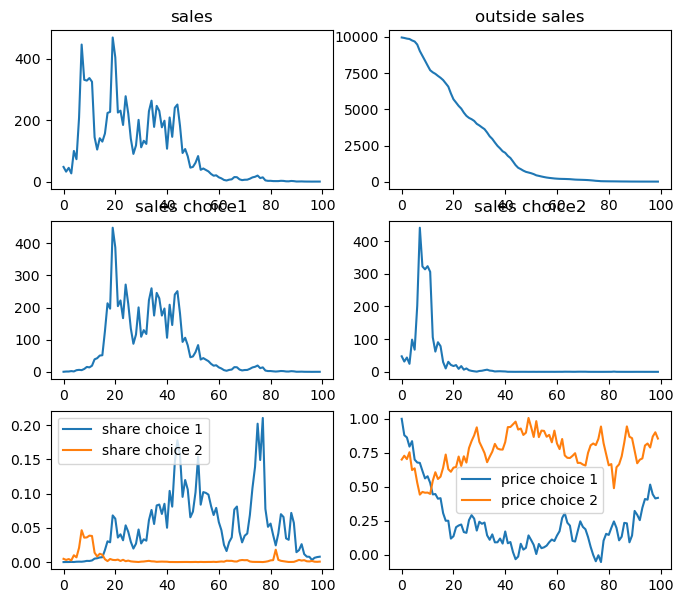

In [483]:
fig, axs = plt.subplots(3, 2, figsize=(8, 7))
axs[0, 0].plot(data.sales)
axs[0, 0].set_title("sales")  
axs[0, 1].plot(data.outside_sales)
axs[0, 1].set_title("outside sales")  
axs[1, 0].plot(data.sales_choice1)
axs[1, 0].set_title("sales choice1")  
axs[1, 1].plot(data.sales_choice2)
axs[1, 1].set_title("sales choice2")  
axs[2, 0].plot(data.share_choice1, label="share choice 1")
axs[2, 0].plot(data.share_choice2, label="share choice 2")
axs[2, 0].legend()
axs[2, 1].plot(data.price_choice1, label="price choice 1")
axs[2, 1].plot(data.price_choice2, label="price choice 2")
axs[2,1].legend()
plt.show

## シェア計算

In [484]:
def calculate_share_MPEC(alpha,beta,rho,cov,xi_choice1,xi_choice2,V0,data):
  
    init_M = data.sales[0]+data.outside_sales[0]

    alpha = alpha
    beta_choice1, beta_choice2 = beta[0], beta[1]

    model = durable_goods_adoption_model(rho=rho,cov=cov,beta=[beta_choice1,beta_choice2],alpha=alpha)
    V0 = model.interpolate_V0(V0,data.price_choice1,data.price_choice2)
   
    share_choice1 = (np.exp(beta_choice1+alpha*data.price_choice1+xi_choice1-V0)/
       (np.exp(V0-V0)+
        np.exp(beta_choice1+alpha*data.price_choice1+xi_choice1-V0)+
        np.exp(beta_choice2+alpha*data.price_choice2+xi_choice2-V0)))

    share_choice2 = (np.exp(beta_choice2+alpha*data.price_choice2+xi_choice2-V0)/
       (np.exp(V0-V0)+
        np.exp(beta_choice1+alpha*data.price_choice1+xi_choice1-V0)+
        np.exp(beta_choice2+alpha*data.price_choice2+xi_choice2-V0)))
       
    share_choice1 = share_choice1.to_numpy()
    share_choice2 = share_choice2.to_numpy()
    share = share_choice1 + share_choice2
    outside_share = 1 - share
    
    M = np.concatenate([np.array([init_M]),(init_M*np.cumprod(outside_share))[:-1]])
    M = np.nan_to_num(M, nan=0)
    
    sales_choice1 = share_choice1*M
    sales_choice2 = share_choice2*M
    outside_sales = outside_share*M
    sales = share*M
        
    prediction = pd.DataFrame(
        np.hstack((sales[:,np.newaxis],outside_sales[:,np.newaxis],
                   sales_choice1[:,np.newaxis],sales_choice2[:,np.newaxis],
                   share[:,np.newaxis],outside_share[:,np.newaxis],
                   share_choice1[:,np.newaxis],share_choice2[:,np.newaxis])),
        columns=["sales","outside_sales","sales_choice1","sales_choice2",
                 "share","outside_share","share_choice1","share_choice2"])  
    
    
    return prediction

V0 = model.solve_vfi()
prediction = calculate_share_MPEC(alpha = model.alpha,
                     beta = model.beta,
                     rho = model.rho,
                     cov = model.cov.flatten(),
                     xi_choice1 = data.xi_choice1,
                     xi_choice2 = data.xi_choice2,
                     V0 = V0,
                     data = data)
prediction

,sales,outside_sales,sales_choice1,sales_choice2,share,outside_share,share_choice1,share_choice2
0,47.874621,9952.125379,0.320978,47.553643,0.004787,0.995213,0.000032,0.004755
1,32.522165,9919.603214,1.001053,31.521112,0.003268,0.996732,0.000101,0.003167
2,44.878762,9874.724453,1.089060,43.789702,0.004524,0.995476,0.000110,0.004414
3,26.850290,9847.874163,2.368729,24.481561,0.002719,0.997281,0.000240,0.002479
4,99.982526,9747.891637,1.359306,98.623220,0.010153,0.989847,0.000138,0.010015
...,...,...,...,...,...,...,...,...
95,0.210631,24.030777,0.187363,0.023268,0.008689,0.991311,0.007729,0.000960
96,0.114231,23.916546,0.074063,0.040168,0.004754,0.995246,0.003082,0.001672
97,0.164455,23.752091,0.150662,0.013793,0.006876,0.993124,0.006299,0.000577
98,0.183953,23.568138,0.174004,0.009949,0.007745,0.992255,0.007326,0.000419


<function matplotlib.pyplot.show(close=None, block=None)>

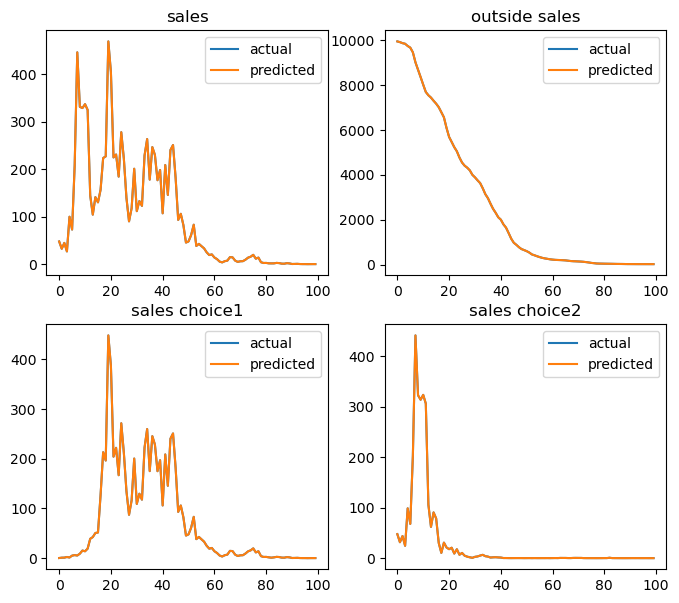

In [487]:
fig, axs = plt.subplots(2, 2, figsize=(8, 7))
axs[0, 0].plot(data.sales,label="actual")
axs[0, 0].plot(prediction.sales,label="predicted")
axs[0, 0].set_title("sales")
axs[0, 0].legend()
axs[0, 1].plot(data.outside_sales,label="actual")
axs[0, 1].plot(prediction.outside_sales,label="predicted")
axs[0, 1].set_title("outside sales")  
axs[0, 1].legend()
axs[1, 0].plot(data.sales_choice1,label="actual")
axs[1, 0].plot(prediction.sales_choice1,label="predicted")
axs[1, 0].set_title("sales choice1")  
axs[1, 0].legend()
axs[1, 1].plot(data.sales_choice2,label="actual")
axs[1, 1].plot(prediction.sales_choice2,label="predicted")
axs[1, 1].set_title("sales choice2") 
axs[1, 1].legend()
plt.show

## 推定

In [488]:
def log_likelihood(theta,data,model):
    
    alpha = theta[0]
    beta = theta[1:3]
    rho = np.array(theta[3:7]).reshape(2,2)
    sigma_psi = theta[7]
    cor = theta[8]
    sigma_xi = theta[9]
    choice_specific_covariance_matrix = np.array([[sigma_psi**2, sigma_psi*cor*sigma_xi,
                                                   sigma_psi*cor*sigma_xi, sigma_xi**2]]).reshape(2,2)
    covariance_matrix = np.array([[choice_specific_covariance_matrix[0,0],0,choice_specific_covariance_matrix[0,1],0],
                                  [0,choice_specific_covariance_matrix[0,0],0,choice_specific_covariance_matrix[0,1]],
                                  [choice_specific_covariance_matrix[0,1],0,choice_specific_covariance_matrix[1,1],0],
                                  [0,choice_specific_covariance_matrix[0,1],0,choice_specific_covariance_matrix[1,1]]])
    V0 = np.array(theta[-(model.ngrid**2+2*len(data)):-2*len(data)])
    V0 = V0.reshape(model.ngrid,model.ngrid)
    xi_choice1 = theta[-2*len(data):-len(data)]
    xi_choice2 = theta[-len(data):]
    
    prediction = calculate_share_MPEC(alpha = alpha,
                         beta = beta,
                         rho = rho,
                         cov = choice_specific_covariance_matrix.flatten(),
                         xi_choice1 = xi_choice1,
                         xi_choice2 = xi_choice2,
                         V0 = V0,
                         data = data)    
    
    psi_choice1 = data.price_choice1[1:]-(rho[0,0]+rho[0,1]*data.price_choice1.shift(1)[1:])
    psi_choice2 = data.price_choice2[1:]-(rho[1,0]+rho[1,1]*data.price_choice2.shift(1)[1:])
    u = np.array([np.array(psi_choice1),np.array(psi_choice2),
              np.array(xi_choice1[1:]),np.array(xi_choice2[1:])]).T
    
    data = data[1:]
    prediction = prediction[1:]
    
    log_lik = 0
    Jacobian_jj_choice1 = prediction.share_choice1*(1-prediction.share_choice1)
    Jacobian_jj_choice2 = prediction.share_choice2*(1-prediction.share_choice2)
    Jacobian_jk_choice1 = -(prediction.share_choice1*prediction.share_choice2)
    Jacobian_jk_choice2 = -(prediction.share_choice2*prediction.share_choice1)

    Jacobian_matrix = np.vstack((np.ones(len(data)).T,np.zeros(len(data)).T,np.zeros(len(data)).T,np.zeros(len(data)).T,
                                  np.zeros(len(data)).T,np.ones(len(data)).T,np.zeros(len(data)).T,np.zeros(len(data)).T,
                                  np.zeros(len(data)).T,np.zeros(len(data)).T,1/Jacobian_jj_choice1,1/Jacobian_jk_choice1,
                                  np.zeros(len(data)).T,np.zeros(len(data)).T,1/Jacobian_jk_choice2,1/Jacobian_jj_choice2)).T.reshape(-1,4,4)

    
#     submatrices = [matrix[2:, 2:] for matrix in Jaccobian_matrix]

#     # 逆行列を計算
#     inverse_submatrices = [np.linalg.inv(submatrix) for submatrix in submatrices]

#     # 元の行列に逆行列をセット
#     Jaccobian_matrix = [np.block([[Jaccobian_matrix[i][:2, :2], np.zeros((2, 2))],
#                                    [np.zeros((2, 2)), inverse_submatrices[i]]]) for i in range(len(Jaccobian_matrix))]

    Jacobian_matrix_det = np.linalg.det(Jacobian_matrix)
    
    mvn = multivariate_normal(mean=[0,0,0,0], cov=covariance_matrix)
    p=mvn.pdf(u)
    #p = multivariate_normal_pdf(u, covariance_matrix=covariance_matrix)*Jaccobian_matrix_det
    #print(p.shape)
    #* Jacobian_matrix_det
    log_lik += np.sum(np.log(np.maximum(p* Jacobian_matrix_det , 1e-30)))
    assert np.all(p>=0), "p should be greater than 0 {}".format(p)
#     assert np.all(Jacobian_matrix_det>= 0), "Jacobian_matrix_det should be greater than 0"
        
    return -log_lik

theta_true = [model.alpha,model.beta[0],model.beta[1],
                      model.rho[0,0],model.rho[0,1],model.rho[1,0],model.rho[1,1],
                      np.linalg.cholesky(model.cov)[0,0],
                      np.linalg.cholesky(model.cov)[1,0],
                      np.linalg.cholesky(model.cov)[1,1]]
theta_true = theta_true + list(V0.flatten()) + list(data.xi_choice1)+list(data.xi_choice2)

log_likelihood(theta=theta_true,
               data=data,model=model)


6838.6777261923135

### 制約条件

In [495]:
def bellman_constraint(theta, model):

    alpha = theta[0]
    beta = theta[1:3]
    rho = np.array(theta[3:7]).reshape(2,2)
    sigma_psi = theta[7]
    cor = theta[8]
    sigma_xi = theta[9]
    choice_specific_covariance_matrix = np.array([[sigma_psi**2, sigma_psi*cor*sigma_xi,
                                                   sigma_psi*cor*sigma_xi, sigma_xi**2]]).reshape(2,2)
    V0 = np.array(theta[-(model.ngrid**2+2*len(data)):-2*len(data)])
    V0 = V0.reshape(model.ngrid,model.ngrid)
    model = durable_goods_adoption_model(beta=beta, alpha=alpha, rho=rho, cov=choice_specific_covariance_matrix)
    
    return (model.bellman(V0) - V0).flatten()

def share_choice1_constraint(theta, data, model=model):
    alpha = theta[0]
    beta = theta[1:3]
    rho = np.array(theta[3:7]).reshape(2,2)
    sigma_psi = theta[7]
    cor = theta[8]
    sigma_xi = theta[9]
    choice_specific_covariance_matrix = np.array([[sigma_psi**2, sigma_psi*cor*sigma_xi,
                                                   sigma_psi*cor*sigma_xi, sigma_xi**2]]).reshape(2,2)
    V0 = np.array(theta[-(model.ngrid**2+2*len(data)):-2*len(data)])
    V0 = V0.reshape(model.ngrid,model.ngrid)
    xi_choice1 = theta[-2*len(data):-len(data)]
    xi_choice2 = theta[-len(data):]

    prediction = calculate_share_MPEC(alpha = alpha,
                         beta = beta,
                         rho = rho,
                         cov = choice_specific_covariance_matrix.flatten(),
                         xi_choice1 = xi_choice1,
                         xi_choice2 = xi_choice2,
                         V0 = V0,
                         data = data)    
    
    return np.array(list(prediction.share_choice1 - data.share_choice1))

def share_choice2_constraint(theta, data, model=model):
    alpha = theta[0]
    beta = theta[1:3]
    rho = np.array(theta[3:7]).reshape(2,2)
    sigma_psi = theta[7]
    cor = theta[8]
    sigma_xi = theta[9]
    choice_specific_covariance_matrix = np.array([[sigma_psi**2, sigma_psi*cor*sigma_xi,
                                                   sigma_psi*cor*sigma_xi, sigma_xi**2]]).reshape(2,2)
    V0 = np.array(theta[-(model.ngrid**2+2*len(data)):-2*len(data)])
    V0 = V0.reshape(model.ngrid,model.ngrid)
    xi_choice1 = theta[-2*len(data):-len(data)]
    xi_choice2 = theta[-len(data):]

    prediction = calculate_share_MPEC(alpha = alpha,
                         beta = beta,
                         rho = rho,
                         cov = choice_specific_covariance_matrix.flatten(),
                         xi_choice1 = xi_choice1,
                         xi_choice2 = xi_choice2,
                         V0 = V0,
                         data = data)    
    
    return np.array(list(prediction.share_choice2 - data.share_choice2))

def cov_constraint(theta):
    choice_specific_covariance_matrix = np.array([[theta[7]**2, theta[7]*theta[8]*theta[9],
                                                   theta[7]*theta[8]*theta[9], theta[9]**2]]).reshape(2,2)
    eigenvalues = np.linalg.eigvals(np.matrix(choice_specific_covariance_matrix)+
                                    np.matrix(choice_specific_covariance_matrix).transpose())
    return eigenvalues
cov_constraint = {'type': 'ineq', 'fun': cov_constraint}


con_bellman = NonlinearConstraint(lambda theta: bellman_type1_constraint(theta, model=model), 0, 0)
con_share_choice1 = NonlinearConstraint(lambda theta: share_choice1_constraint(theta, data, model=model), 0, 0)
con_share_choice2 = NonlinearConstraint(lambda theta: share_choice2_constraint(theta, data, model=model), 0, 0)
constraints = [con_bellman, con_share_choice1, con_share_choice2 ,cov_constraint]

In [496]:
theta_init = [-0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.5,0.1,0.5]
theta_init = theta_init + list(np.ones(len(V0.flatten())))
theta_init = theta_init + list(np.zeros(len(data.xi_choice1)))
theta_init = theta_init + list(np.zeros(len(data.xi_choice2)))

### 最適化

In [497]:
con_bellman_type1 = NonlinearConstraint(lambda theta: bellman_type1_constraint(theta, model=model), 0, 0)
con_bellman_type2 = NonlinearConstraint(lambda theta: bellman_type2_constraint(theta, model=model), 0, 0)
con_share = NonlinearConstraint(lambda theta: share_constraint(theta, data, model=model), 0, 0)
warnings.filterwarnings("ignore", message="delta_grad == 0.0. Check if the approximated function is linear.")
lb = np.zeros((len(theta_init)))
ub = np.zeros((len(theta_init)))
lb[0:-(model.ngrid**2+2*len(data))] = [-10, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ub[0:-(model.ngrid**2+2*len(data))] = [ 0, 10, 10, 5, 1, 5, 1, 2, 1, 2]
lb[-(model.ngrid**2+2*len(data)):-2*len(data)] = -10
lb[-2*len(data):]=-1
ub[-(model.ngrid**2+2*len(data)):-2*len(data)] = 10
ub[-2*len(data):]= 1

bounds = Bounds(lb, ub)
result = minimize(log_likelihood,
              theta_init,
              args=(data, model),
              method='trust-constr',
              jac="2-point",
              hess=BFGS(),
              constraints=constraints,
              bounds=bounds)
result.x

array([-7.36055478e+00,  4.93878431e-03,  9.16948961e-01,  2.90529027e-01,
        5.42750766e-01,  1.06352046e+00,  3.79637617e-01,  4.48384367e-01,
        2.19299731e-01,  4.99951150e-01,  1.51441019e+00,  1.51362516e+00,
        1.51104660e+00,  1.50999855e+00,  1.50843182e+00,  1.50693049e+00,
        1.50558062e+00,  1.50430922e+00,  1.50294401e+00,  1.50137250e+00,
        1.50076961e+00,  1.49930586e+00,  1.49927083e+00,  1.49869424e+00,
        1.49768209e+00,  1.49663335e+00,  1.49568236e+00,  1.49524957e+00,
        1.49369893e+00,  1.49195338e+00,  1.46730451e+00,  1.46546560e+00,
        1.46251607e+00,  1.46089128e+00,  1.45879680e+00,  1.45668839e+00,
        1.45469916e+00,  1.45291924e+00,  1.45094094e+00,  1.44866026e+00,
        1.44735841e+00,  1.44530300e+00,  1.44461748e+00,  1.44336819e+00,
        1.44180262e+00,  1.44020837e+00,  1.43868419e+00,  1.43765505e+00,
        1.43496286e+00,  1.43400077e+00,  1.42919145e+00,  1.42739705e+00,
        1.42421661e+00,  

<function matplotlib.pyplot.show(close=None, block=None)>

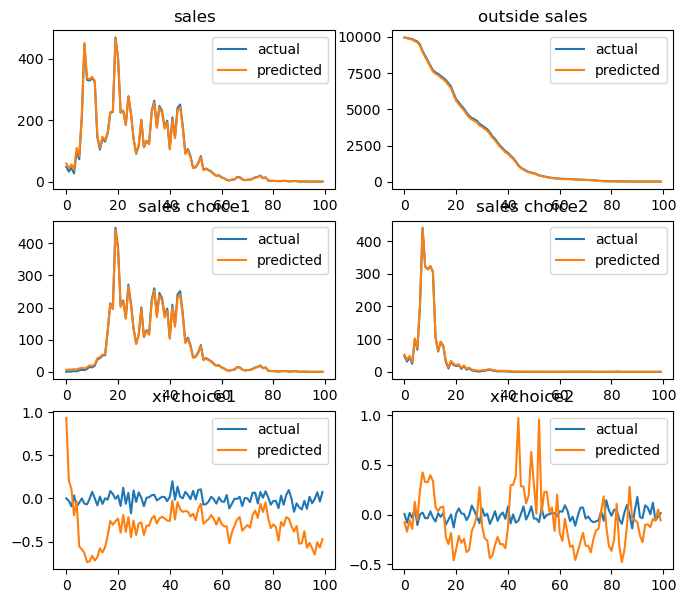

In [500]:
alpha = result.x[0]
beta = result.x[1:3]
rho = np.array(result.x[3:7]).reshape(2,2)
sigma_psi = result.x[7]
cor = result.x[8]
sigma_xi = result.x[9]
choice_specific_covariance_matrix = np.array([[sigma_psi**2, sigma_psi*cor*sigma_xi,
                                               sigma_psi*cor*sigma_xi, sigma_xi**2]]).reshape(2,2)
covariance_matrix = np.array([[choice_specific_covariance_matrix[0,0],0,choice_specific_covariance_matrix[0,1],0],
                              [0,choice_specific_covariance_matrix[0,0],0,choice_specific_covariance_matrix[0,1]],
                              [choice_specific_covariance_matrix[0,1],0,choice_specific_covariance_matrix[1,1],0],
                              [0,choice_specific_covariance_matrix[0,1],0,choice_specific_covariance_matrix[1,1]]])
V0 = np.array(result.x[-(model.ngrid**2+2*len(data)):-2*len(data)])
V0 = V0.reshape(model.ngrid,model.ngrid)
xi_choice1 = result.x[-2*len(data):-len(data)]
xi_choice2 = result.x[-len(data):]

prediction = calculate_share_MPEC(alpha = alpha,
                     beta = beta,
                     rho = rho,
                     cov = choice_specific_covariance_matrix.flatten(),
                     xi_choice1 = xi_choice1,
                     xi_choice2 = xi_choice2,
                     V0 = V0,
                     data = data)    

fig, axs = plt.subplots(3, 2, figsize=(8, 7))
axs[0, 0].plot(data.sales,label="actual")
axs[0, 0].plot(prediction.sales,label="predicted")
axs[0, 0].set_title("sales")
axs[0, 0].legend()
axs[0, 1].plot(data.outside_sales,label="actual")
axs[0, 1].plot(prediction.outside_sales,label="predicted")
axs[0, 1].set_title("outside sales")  
axs[0, 1].legend()
axs[1, 0].plot(data.sales_choice1,label="actual")
axs[1, 0].plot(prediction.sales_choice1,label="predicted")
axs[1, 0].set_title("sales choice1")  
axs[1, 0].legend()
axs[1, 1].plot(data.sales_choice2,label="actual")
axs[1, 1].plot(prediction.sales_choice2,label="predicted")
axs[1, 1].set_title("sales choice2") 
axs[1, 1].legend()
axs[2, 0].plot(data.xi_choice1,label="actual")
axs[2, 0].plot(xi_choice1, label="predicted" )
axs[2 ,0].legend()
axs[2, 0].set_title("xi choice1")
axs[2, 1].plot(data.xi_choice2,label="actual")
axs[2, 1].plot(xi_choice2, label="predicted" )
axs[2 ,1].legend()
axs[2, 1].set_title("xi choice2")
plt.show

In [503]:
print(bellman_constraint(theta=result.x, model=model))
print(share_choice1_constraint(theta=result.x, data=data, model=model))
print(share_choice2_constraint(theta=result.x, data=data, model=model))

[ 1.64229977e-04 -1.01168600e-03 -2.78672333e-04 -9.09001530e-04
 -9.33514805e-04 -9.81489101e-04 -1.13679048e-03 -1.29802250e-03
 -1.19876884e-03 -8.19312618e-04 -1.35648131e-03 -9.98531508e-04
 -2.01535869e-03 -2.46949602e-03 -2.45687473e-03 -2.36342399e-03
 -2.32269774e-03 -2.76199088e-03 -2.04699152e-03 -1.10910936e-03
  1.99831912e-03  1.45672708e-03  2.14297332e-03  1.67485090e-03
  1.76477810e-03  1.90990262e-03  1.97957361e-03  1.91351132e-03
  2.21719617e-03  2.89845823e-03  2.65387134e-03  3.19815042e-03
  2.42734244e-03  2.23951195e-03  2.39847149e-03  2.63106091e-03
  2.83953161e-03  2.59180469e-03  4.04462584e-03  3.79600845e-03
 -8.83547592e-04 -1.74596392e-03 -1.10335787e-03 -1.69872571e-03
 -1.68793230e-03 -1.70581025e-03 -1.74251910e-03 -1.86438103e-03
 -1.65782450e-03 -1.11973071e-03 -1.54298489e-03 -1.15270088e-03
 -2.09780226e-03 -2.47609449e-03 -2.47811766e-03 -2.38853373e-03
 -2.34562143e-03 -2.77549893e-03 -1.64085305e-03 -1.59437111e-03
  1.13925507e-03  2.03438

フィッティングはうまくいっているが推定値にバイアスがある。これはベルマン方程式とシェアの等式制約が完全に満たされていないことによるバイアスと時系列データ推定でよく起こるデータが十分に多くないことによるバイアスの二通りが考えられる。